# Estimate the parasitic neutron attenuation in the target

- import kaeri data
- calculate (averaged) cross sections
- calculate attenuation coefficient
- compute fraction of attenuated neutrons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import matplotlib
os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2018/bin/x86_64-darwin'
plt.rc('text', usetex=True)
plt.rc('font', weight='bold')
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.bf'] = 'Arial:bold'
matplotlib.rcParams['mathtext.tt'] = 'Arial'
matplotlib.rcParams['mathtext.cal'] = 'Arial'
matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

## import kaeri data

List of the isotopes
- copper: Cu-63 (69.15%), Cu-65 (30.85%), density 8.96 g/cm3
- water: H-1, O-16, density 1 g/cm3
- titanium: Ti-46 (8.25%), Ti-47 (7.44%), Ti-48 (73.72%), Ti-49 (5.41%), Ti-50 (5.18%), density 4.506 g/cm3

In [3]:
properties_Cu = {'material': 'copper',
                 'isotopes': ['Cu-63', 'Cu-65'],
                 'density': 8.96,
                 'abundances': [69.15/100, 30.85/100],
                 'Mol': 63.546
             }

properties_H2O = {'material': 'water',
                 'isotopes': ['H-1', 'O-16'],
                 'density': 1,
                 'abundances': [2, 1],
                 'Mol': 18.01528
             }

properties_Ti = {'material': 'titanium',
                 'isotopes': ['Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50'],
                 'density': 4.506,
                 'abundances': [8.25/100, 7.44/100, 73.72/100, 5.41/100, 5.18/100],
                 'Mol': 47.867
             }
properties = {'Cu': properties_Cu,
             'H2O': properties_H2O,
             'Ti': properties_Ti}



In [4]:
# get the microscopic attenuation coefficient
path = '/Users/hkromer/02_PhD/02_Data/04.xs/'

for material in properties.keys():
    abundances = properties[material]['abundances']
    isotopes = properties[material]['isotopes']

    xs = []

    for a, i in zip(abundances, isotopes):
        sig = pd.read_csv(f'{path}/{i}.n_tot.txt', skiprows=1, header=0, delimiter=' ')
        cols = ['E', 'xs']
        # energy in eV, xs in 1e-24cm**2
        sig.columns = cols
        # select only range from 2 to 3 MeV
        sig = sig[ (sig['E'] >= 2e6) & ((sig['E'] <= 3e6)) ]

        sig_av = sig['xs'].mean() # average in 2-3 MeV range
        sig_av = sig_av * 1e-24 # convert to cm2
        print(material, sig_av)
        xs.append(sig_av)

    xs = np.array(xs)
    ab = np.array(abundances)

    sigma = np.sum(xs * ab)
    
    properties[material]['sigma'] = sigma
    


Cu 3.151426410256411e-24
Cu 3.133873571428572e-24
H2O 2.569463333333333e-24
H2O 8.43850466666667e-25
Ti 3.659402222222222e-24
Ti 3.7341725000000005e-24
Ti 3.443489266055046e-24
Ti 3.828247999999999e-24
Ti 3.85398125e-24


In [5]:
# calculates the macroscopic cross section (attenuation coefficient)
def Sigma(rho, Mol, sigma):
    N_avog = 6.022e23
    return (N_avog*rho/Mol)*sigma

for material in properties.keys():
    xs = properties[material]['sigma']
    rho = properties[material]['density']
    Mol = properties[material]['Mol']
    
    properties[material]['att_coeff'] = Sigma(rho, Mol, xs)
    


In [6]:
properties['Ti']

{'material': 'titanium',
 'isotopes': ['Ti-46', 'Ti-47', 'Ti-48', 'Ti-49', 'Ti-50'],
 'density': 4.506,
 'abundances': [0.0825, 0.07440000000000001, 0.7372, 0.0541, 0.0518],
 'Mol': 47.867,
 'sigma': 3.525007849819113e-24,
 'att_coeff': 0.19982775880226003}

In [7]:
properties['Cu']

{'material': 'copper',
 'isotopes': ['Cu-63', 'Cu-65'],
 'density': 8.96,
 'abundances': [0.6915, 0.3085],
 'Mol': 63.546,
 'sigma': 3.146011359478023e-24,
 'att_coeff': 0.267128871124412}

In [8]:
properties['H2O']

{'material': 'water',
 'isotopes': ['H-1', 'O-16'],
 'density': 1,
 'abundances': [2, 1],
 'Mol': 18.01528,
 'sigma': 5.9827771333333334e-24,
 'att_coeff': 0.19998736570807302}

## Compute fraction of attenuated neutrons

In [9]:
# copper thicknesses
d_Cus = np.arange(1, 8, 1)
d_walls = np.arange(1, 4, 1)
d_waters = np.arange(1, 5, 1)


Make a plot for each water thickness. The different lines are for different wall thicknesses. The x axis is the copper layer thickness (the outer copper layer), the y axis is the fraction of attenuated neutrons.

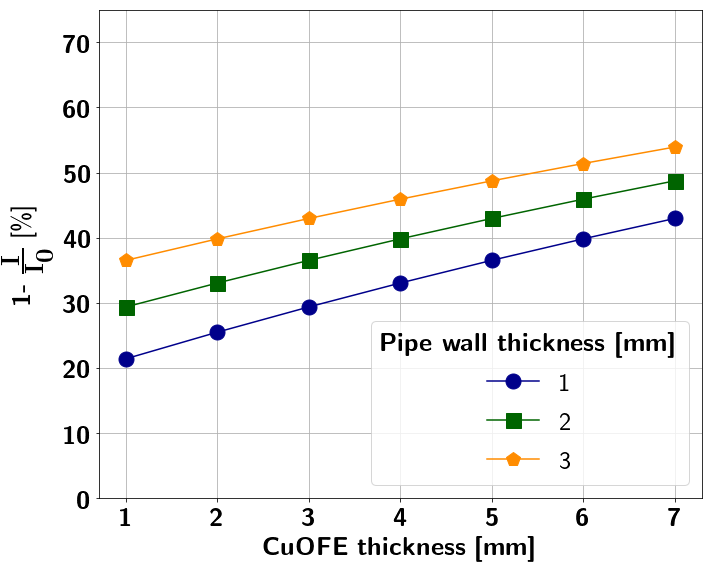

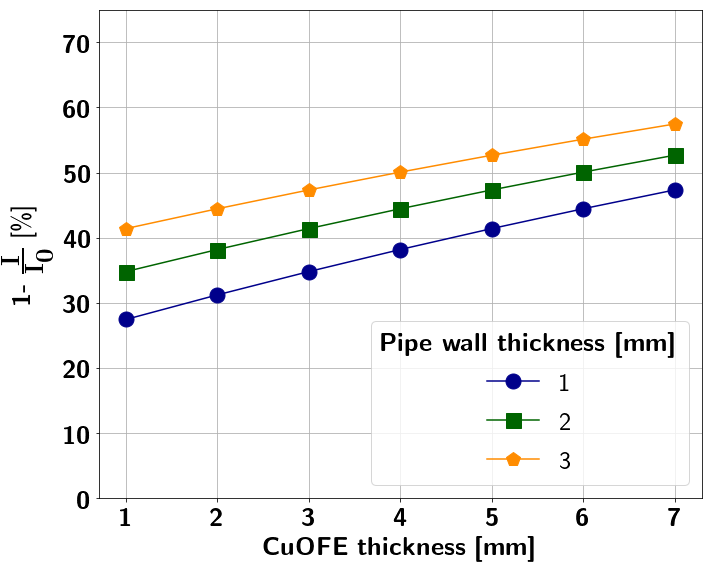

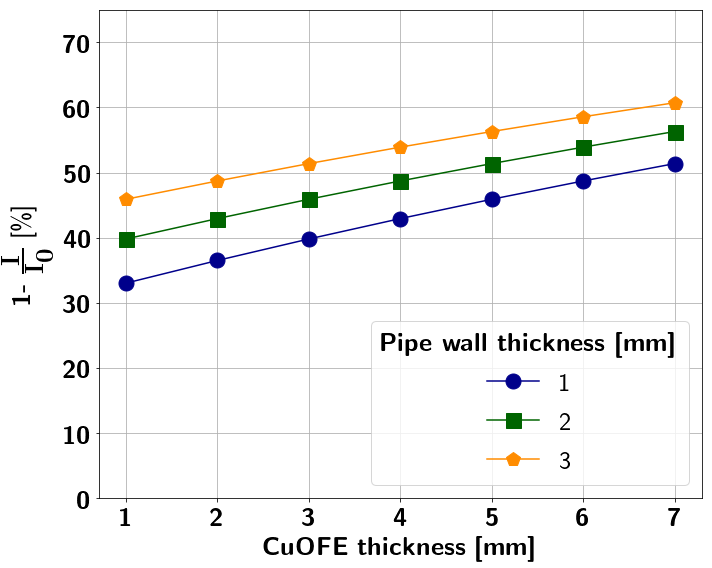

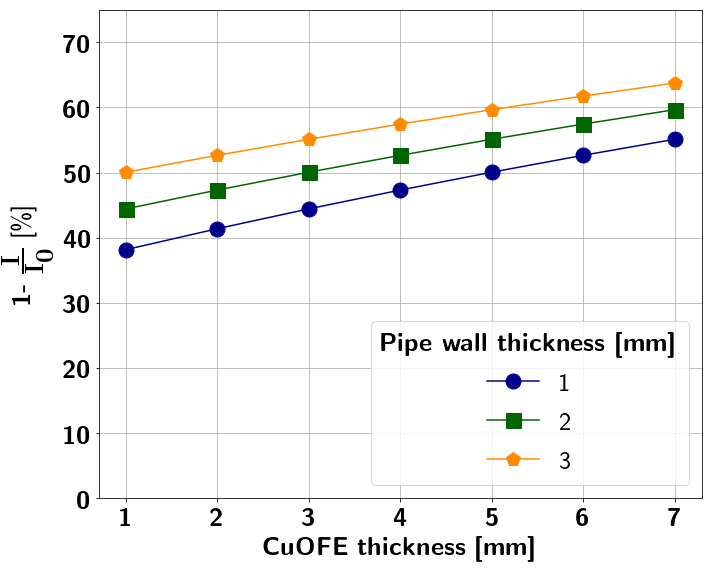

34.77442839718863

In [14]:
def fracAttNeutrons(prop, d_water, d_Cu, d_wall, d_Ti):  # d are in mm! 
    # prop is the properties dictionary 
    # Cu
    f_Cu = np.exp(-prop['Cu']['att_coeff'] * (d_Cu/10)*2)
    f_wall = np.exp(-prop['Cu']['att_coeff'] * (d_wall/10)*4)
    f_Ti = np.exp(-prop['Ti']['att_coeff'] * (d_Ti/10)*2)
    f_water = np.exp(-prop['H2O']['att_coeff'] * (d_water/10)*4)
    return (1-(f_Cu * f_wall * f_Ti * f_water))*100

folder = '/Users/hkromer/polybox/Thesis/Figures/03.RotatingTarget/parasitic_attenuation/'
colors = ['darkblue', 'darkgreen', 'darkorange']
markers = ['o', 's', 'p']
fs = 16+10
ls = 16+10

d_Ti = 5e-3

for d_water in d_waters:
    plt.figure(figsize=(10,8))
    for c, m, d_wall  in zip(colors, markers, d_walls):
        # plot
        plt.plot(d_Cus, fracAttNeutrons(properties, d_water, d_Cus, d_wall, d_Ti), marker=m, markersize=15, c=c, label=f'{d_wall}')

    ax = plt.gca()
#     ylim = ax.get_ylim()
#     plt.ylim(ylim)
    ax.tick_params(axis = 'both', which = 'major', labelsize = ls)
#     ax.text(-17.5, 365, r'\textbf{Cu}', color='black', fontsize=fs)
#     ax.text(-16.75, 365, r'\textbf{Water}', color='black', fontsize=fs)
    plt.grid()
    plt.xlabel(r'\textbf{CuOFE thickness [mm]}', fontsize=fs)
    plt.ylabel(r'\textbf{1-} $\frac{\textrm{\textbf{I}}}{\textrm{\textbf{I}}_{\textrm{\textbf{0}}}}$ [\%]', fontsize=fs)
    plt.ylim(0, 75)
    handles,labels = ax.get_legend_handles_labels()

    handles = [handles[0], handles[1], handles[2]]
    labels = [labels[0], labels[1], labels[2]]

    legend = ax.legend(handles,labels,title=r'\textbf{Pipe wall thickness [mm]}',loc='lower right', fontsize=fs)
#     plt.title('Water layer thickness ' + str(d_water) + r' mm', fontsize=fs)

    plt.setp(legend.get_title(),fontsize=fs)
    plt.tight_layout()
    plt.savefig(f'{folder}/parasitic_attenuation_d_water_{d_water}mm.pdf', dpi=600)
    
    plt.show()
    plt.close()
    
fracAttNeutrons(properties, 2, 3, 1, 5e-3)